## Preprocessing the Raw Data Underpinning `tell`

In this notebook we will load and process the necessary data for `tell`. The raw data (i.e., historical loads, population, meteorology, etc.) is in a variety of different formats determined by their originating organization (e.g., the Energy Information Agency). This series of processing steps cleans the raw data and converts it into a set of simplified .csv files which can be combined together and used as input to the MLP model training steps in `tell`. Follow the sequence below to pre-process the `tell` input data.

### Install the package of data underpinning `tell`

`tell` is based on open-source publicly accessible data. For convienence, we've packaged all of the core data underpinning tell into a [Zenodo data package](https://zenodo.org/record/5714756#.YhkTjxPMJTY). In order to run this notebook, first set the local directory where you would like to store the package data and the run the `install_tell_raw_data` function below. Note that the raw data package will require ~1.6 GB of storage and can take several minutes to download.

In [1]:
# Start by importing the `tell` package and information about your operating system:
import os 
import tell


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
# Identify the current working directory, the subdirectory where the data will be stored, and the image output subdirectory:
current_dir =  os.path.join(os.path.dirname(os.getcwd()))
tell_data_dir = os.path.join(current_dir, r'tell_data')
tell_image_dir = os.path.join(tell_data_dir, r'visualizations')

# If the "tell_data_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_data_dir):
   os.makedirs(tell_data_dir)

# If the "tell_image_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_image_dir):
   os.makedirs(tell_image_dir)


In [4]:
# Download the TELL raw data package from Zenodo:
tell.install_tell_raw_data(data_dir = tell_data_dir)


Done!


In [6]:
tell_data_dir

'/Users/ansonkong/Downloads/tell_data'

### Spatially mapping BAs to counties

The code block underpins the spatial component of `tell`. The function `map_ba_service_territory` uses information about Balancing Authorities (BAs) from the [EIA-861](https://www.eia.gov/electricity/data/eia861/) dataset to spatially map BAs to U.S. counties. This allows us to assign loads projected for individual BAs in `tell` to where they would occur with respect to each other spatially. More information about how BAs are mapped is available on the [Read the Docs](https://immm-sfa.github.io/tell/index.html) site for `tell`.

In [4]:
# Execute the mapping function for all years from 2015 to 2020:
tell.map_ba_service_territory(start_year = 2015,
                              end_year = 2020,
                              data_input_dir = tell_data_dir)


In [12]:
tell.data_spatial_mapping.process_spatial_mapping(2040,
                                                  '/Users/ansonkong/Downloads/tell_data/tell_raw_data/state_and_county_fips_codes.csv',
                                                  '/Users/ansonkong/Downloads/tell_data/tell_raw_data/EIA_861/2020/Service_Territory_2020.xlsx',
                                                  '/Users/ansonkong/Downloads/tell_data/tell_raw_data/EIA_861/2020/Sales_Ult_Cust_2020.xlsx',
                                                  '/Users/ansonkong/Downloads/tell_data/tell_raw_data/EIA_861/2020/Balancing_Authority_2020.xlsx',
                                                  os.path.join(os.path.join(os.path.dirname(os.getcwd()))))

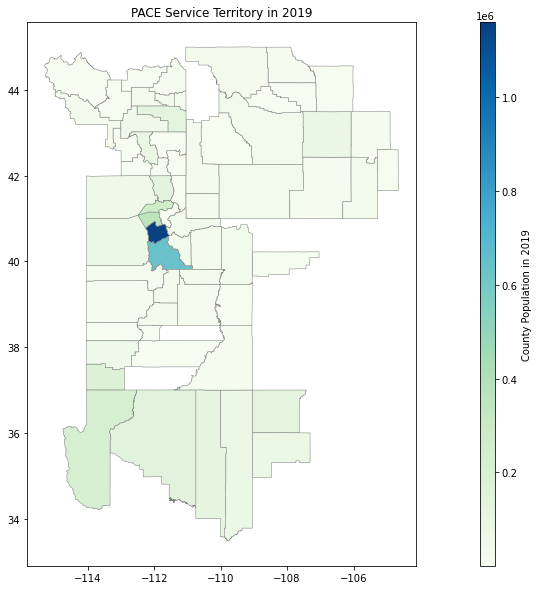

In [5]:
# See the output of the mapping step by plotting the service territory for a given BA (e.g., PJM, CISO, ERCO, etc.) in a given year (e.g., 2015-2020):
tell.plot_ba_service_territory(ba_to_plot = 'PACE',
                               year_to_plot = '2019',
                               data_input_dir = tell_data_dir, 
                               image_output_dir = tell_image_dir,
                               image_resolution = 150,
                               save_images = False)


In [16]:
tell.install_forcing_data.install_sample_forcing_data(data_dir=tell_data_dir)

Done!


In [19]:
from tell.execute_forward import execute_forward

result=execute_forward('2039', 'rcp85hotter_ssp5', tell_data_dir, save_county_data=False)


Start time =  2024-02-14 00:06:15.953063


/opt/anaconda3/lib/python3.9/site-packages/tell/execute_forward.py:120: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  population_interp_df = population_dft.resample('1Y').mean().interpolate('linear').T


End time =  2024-02-14 00:08:02.255788
Elapsed time =  0:01:46.303210


In [21]:
result[2].to_csv('/Users/ansonkong/Downloads/testing_result')

### Process the EIA-930 historical hourly demand dataset

Here we convert the raw EIA-930 hourly electricity demand data for BAs from Excel files to .csv files. The function `process_eia_930_data` also subsets the EIA-930 dataset to only include the desired variables. Note that this step can take a few minutes even when using parallel processing streams.

In [ ]:
# Execute the function to pre-proceess the raw EIA-930 data using parallel processing streams:
tell.process_eia_930_data(data_input_dir = tell_data_dir,
                          n_jobs = -1)


### Process the historical population dataset

This pre-processing step takes historical county-level population data from the U.S. Census Bureau and computes the total population living within the service territory of each BA. The historical annual populations are then interpolated to an hourly resolution in preparation to use population as input to the MLP models.

In [ ]:
# Execute the function to pre-process the historical observed population data for all years from 2015 to 2020:
tell.process_ba_population_data(start_year = 2015,
                                end_year = 2020,
                                data_input_dir = tell_data_dir)


### Download the sample historical and future meteorology data

This pre-processing step relies on another pre-packaged sample dataset containing historical and sample future weather data used in `tell`. This sample forcing data is also available from a [Zenodo data package](https://zenodo.org/record/6354665#.Yi-_PRDMJTY). This section downloads that sample forcing data. The historical and future meteorology is based on IM3 simulations using the Weather Research and Forecasting (WRF) model. Meteorological output from WRF is first averaged into county-level mean values and then population-weighted to create an hourly time series of meteorology for each BA in `tell`.  Note that the sample weather data package will require ~250 MB of storage and can take several minutes to download.

In [ ]:
# Download the TELL sample forcing data package from Zenodo:
tell.install_sample_forcing_data(data_dir = tell_data_dir)


### Compile the historical hourly load, population, and meteorology data 

In this final pre-processing step we compile the historical load, population, and meteorology data into a single set of .csv files. There is one .csv file generated for each BA in `tell`. These composite .csv files are then used as input to the MLP model training. Note that this step can take a few minutes.

In [ ]:
# Compile the historical load, population, and meteorology data into a single set of .csv files:
tell.compile_data(start_year = 2015,
                  end_year = 2019,
                  data_input_dir = tell_data_dir)


In [6]:
!pip install --upgrade openpyxl


     |████████████████████████████████| 249 kB 2.1 MB/s eta 0:00:01
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


In [23]:
import geopandas as gpd

# Load the shapefile
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
ba_subregions = gpd.read_file(shapefile_path)

# Filter for 'PJM INTERCONNECTION, LLC' and 'NOT AVAILABLE' in 'CNTRL_AREA'
filter_criteria = ['PJM INTERCONNECTION, LLC', 'NOT AVAILABLE']
filtered_subregions = ba_subregions[ba_subregions['CNTRL_AREA'].isin(filter_criteria)]

# Adjust column names to replace spaces with underscores AFTER filtering to ensure consistency
filtered_subregions.columns = [col.replace(' ', '_') for col in filtered_subregions.columns]

# Get distinct 'NAME' values from the filtered GeoDataFrame
distinct_names = filtered_subregions['NAME'].unique()

# Print all distinct 'NAME' values for the specified 'CNTRL_AREA' values
print("Distinct NAME values for 'PJM INTERCONNECTION, LLC' and 'NOT AVAILABLE':")
for name in distinct_names:
    print(name)


Distinct NAME values for 'PJM INTERCONNECTION, LLC' and 'NOT AVAILABLE':
KAUAI ISLAND UTILITY COOPERATIVE
KETCHIKAN PUBLIC UTILITIES
TOWN OF AVILLA - (IN)
KINGSPORT POWER CO
TOWN OF KNIGHTSTOWN - (IN)
KODIAK ELECTRIC ASSN INC
KOTZEBUE ELECTRIC ASSN INC
KOKHANOK VILLAGE COUNCIL
KWIG POWER COMPANY
BOROUGH OF KUTZTOWN - (PA)
VILLAGE OF LAKEVIEW - (OH)
BARC ELECTRIC COOP INC
LICKING RURAL ELECTRIC INC
BOROUGH OF LANSDALE
BOROUGH OF LAVALLETTE - (NJ)
CITY OF LEBANON - (OH)
BOROUGH OF LEHIGHTON - (PA)
CITY OF LEWES - (DE)
BOROUGH OF LEWISBERRY - (PA)
LICKING VALLEY RURAL E C C
VILLAGE OF LODI - (OH)
LORAIN-MEDINA R E C, INC
LOGAN COUNTY COOP POWER & LIGHT
VILLAGE OF LUCAS - (OH)
BOROUGH OF MADISON - (NJ)
CITY OF MANASSAS - (VA)
BALTIMORE GAS & ELECTRIC CO
VILLAGE OF MARSHALLVILLE - (OH)
CITY OF MARTINSVILLE - (VA)
ADAMS RURAL ELECTRIC COOP, INC
MATANUSKA ELECTRIC ASSN INC
MAUI ELECTRIC CO LTD
MATINICUS PLANTATION ELEC CO
MCGRATH LIGHT & POWER CO
MECKLENBURG ELECTRIC COOPERATIVE
CITY OF MENDO